<a href="https://colab.research.google.com/github/ptl-harsh/QLab_Task/blob/main/P1T3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Multivariate Time series forecasting using Conditional Diffusion Model (DDPM):

In [2]:
#@title Step 1: Install and Import Required Libraries
!pip install torch torchvision torchaudio numpy pandas scikit-learn matplotlib tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


In [3]:
#@title Step 2: Load and Preprocess Data from CSV Files

# Update these file names if necessary.
train_path = "/content/timeseries_train.csv"  # Upload your CSV file to Colab
test_path  = "/content/timeseries_test.csv"   # Upload your CSV file to Colab

# Read CSV files (adjust separator if needed)
df_train = pd.read_csv(train_path, sep=",")
df_test  = pd.read_csv(test_path, sep=",")

# Inspect the columns to confirm expected names.
print("Train Columns:", df_train.columns.tolist())
print("Test Columns:", df_test.columns.tolist())

# Drop non-numeric columns: here we assume columns "Time", "year", "month", "day" are non-numeric.
drop_cols = ["Time", "year", "month", "day"]
df_train_features = df_train.drop(columns=drop_cols)
df_test_features  = df_test.drop(columns=drop_cols)

# Convert to numpy arrays (float32)
train_data = df_train_features.values.astype(np.float32)
test_data  = df_test_features.values.astype(np.float32)

# Normalize the data using StandardScaler
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data  = scaler.transform(test_data)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train Columns: ['Time', 'year', 'month', 'day', 'Sl_cor', 'so_m3', 'thetao_m3', 'M_eta', 'M_xi', 'V_eta', 'V_xi', 'tp']
Test Columns: ['Time', 'year', 'month', 'day', 'Sl_cor', 'so_m3', 'thetao_m3', 'M_eta', 'M_xi', 'V_eta', 'V_xi', 'tp']
Train data shape: (388, 8)
Test data shape: (364, 8)


In [4]:
#@title Step 3: Create Sequences for Forecasting

# We use a historical sequence length of 96 and forecast horizon of 14.
SEQ_LEN = 96
PRED_LEN = 14

def create_sequences(data, seq_len, pred_len):
    """
    Generates overlapping sequences and corresponding targets.
    data: numpy array of shape (num_timesteps, num_features)
    Returns:
      X: (num_samples, seq_len, num_features)
      y: (num_samples, pred_len, num_features)
    """
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len : i + seq_len + pred_len])
    return np.array(X), np.array(y)

# Create sequences for train and test data
X_train, y_train = create_sequences(train_data, SEQ_LEN, PRED_LEN)
X_test, y_test   = create_sequences(test_data, SEQ_LEN, PRED_LEN)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)


X_train shape: (279, 96, 8)
y_train shape: (279, 14, 8)
X_test shape: (255, 96, 8)
y_test shape: (255, 14, 8)


In [5]:
#@title Step 4: Define the Conditional Diffusion Model (DDPM)
# This is a simplified DDPM model for conditional forecasting.
class ConditionalDiffusionModel(nn.Module):
    def __init__(self, input_size, seq_len, pred_len, timesteps=1000):
        """
        input_size: Number of features.
        seq_len: Length of historical sequence (e.g., 96).
        pred_len: Forecast horizon (e.g., 14).
        timesteps: Total number of diffusion steps.
        """
        super(ConditionalDiffusionModel, self).__init__()
        self.timesteps = timesteps
        # Encoder: Flatten the historical sequence and project it
        self.encoder = nn.Sequential(
            nn.Linear(seq_len * input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        # Decoder: Combine the encoded representation with timestep embedding to produce forecast.
        self.decoder = nn.Sequential(
            nn.Linear(128 + 1, 128),
            nn.ReLU(),
            nn.Linear(128, pred_len * input_size)
        )

    def forward(self, x, t):
        """
        x: Historical sequence, shape [batch, seq_len, input_size].
        t: Timestep, shape [batch] (integer values from 0 to timesteps-1).
        """
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1)  # Flatten to shape [batch, seq_len * input_size]
        enc = self.encoder(x_flat)       # Encoded representation: [batch, 128]

        # Normalize timestep and reshape to [batch, 1]
        t_norm = (t.float() / self.timesteps).unsqueeze(1)
        # Concatenate encoded data with timestep embedding
        cond = torch.cat([enc, t_norm], dim=1)  # shape: [batch, 128 + 1]
        out = self.decoder(cond)  # shape: [batch, pred_len * input_size]
        return out.view(batch_size, PRED_LEN, -1)  # Reshape to [batch, pred_len, input_size]

# Initialize model
input_size = X_train.shape[2]  # Number of features
timesteps = 1000
model = ConditionalDiffusionModel(input_size, SEQ_LEN, PRED_LEN, timesteps)
print(model)


ConditionalDiffusionModel(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=112, bias=True)
  )
)


In [6]:
#@title Step 5: Train the Model

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50
BATCH_SIZE = 32

# Create a DataLoader for training data
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model.train()
for epoch in range(EPOCHS):
    epoch_losses = []
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        # Sample a random timestep for each batch sample
        t = torch.randint(0, timesteps, (batch_x.shape[0],))
        outputs = model(batch_x, t)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    avg_loss = np.mean(epoch_losses)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.6f}")


Epoch 5/50 - Loss: 0.394404
Epoch 10/50 - Loss: 0.291386
Epoch 15/50 - Loss: 0.219183
Epoch 20/50 - Loss: 0.183842
Epoch 25/50 - Loss: 0.153533
Epoch 30/50 - Loss: 0.134632
Epoch 35/50 - Loss: 0.119232
Epoch 40/50 - Loss: 0.105843
Epoch 45/50 - Loss: 0.093356
Epoch 50/50 - Loss: 0.084109


In [7]:
#@title Step 6: Evaluate the Model on Test Data

model.eval()
with torch.no_grad():
    # For evaluation, you can sample random timesteps for each test sample.
    t_test = torch.randint(0, timesteps, (X_test_tensor.shape[0],))
    predictions = model(X_test_tensor, t_test)  # shape: [num_samples, PRED_LEN, input_size]
    predictions_np = predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# To evaluate errors, we need to reverse the normalization.
# Since we normalized multivariate data, we reshape to 2D arrays.
predictions_2d = predictions_np.reshape(-1, input_size)
y_test_2d = y_test_np.reshape(-1, input_size)

# Inverse transform the predictions and true values.
predictions_inv = scaler.inverse_transform(predictions_2d)
y_test_inv = scaler.inverse_transform(y_test_2d)

# Reshape back to [num_samples, PRED_LEN, input_size]
predictions_final = predictions_inv.reshape(-1, PRED_LEN, input_size)
y_test_final = y_test_inv.reshape(-1, PRED_LEN, input_size)

# Calculate multivariate MSE and MAE over all features.
mse_multivariate = mean_squared_error(y_test_inv, predictions_inv)
mae_multivariate = mean_absolute_error(y_test_inv, predictions_inv)

print("Multivariate Metrics:")
print("MSE:", mse_multivariate)
print("MAE:", mae_multivariate)

# For univariate evaluation, consider the last feature (e.g., 'tp').
y_test_last = y_test_inv[:, -1]
pred_last = predictions_inv[:, -1]
mse_univariate = mean_squared_error(y_test_last, pred_last)
mae_univariate = mean_absolute_error(y_test_last, pred_last)

print("\nUnivariate Metrics (Last Feature):")
print("MSE:", mse_univariate)
print("MAE:", mae_univariate)


Multivariate Metrics:
MSE: 161345344.0
MAE: 4345.0400390625

Univariate Metrics (Last Feature):
MSE: 0.00011227214417885989
MAE: 0.007345886435359716


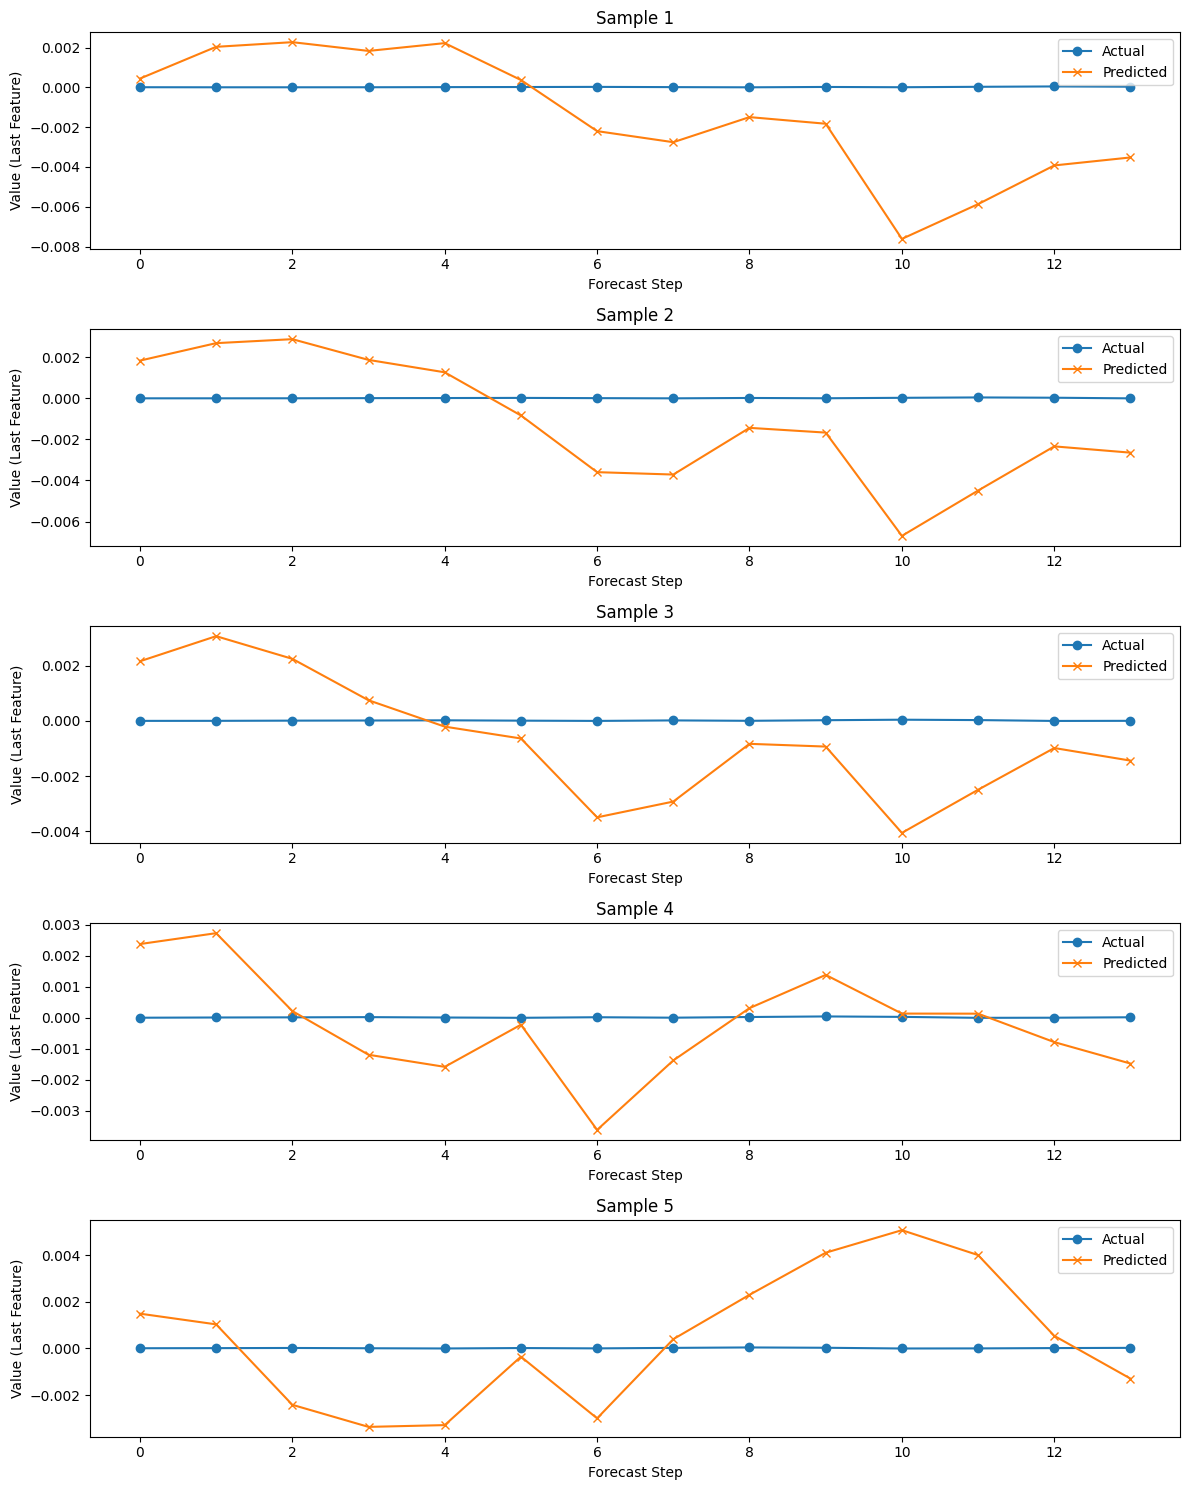

In [8]:
#@title Step 7: Visualize Forecast Results

# For visualization, plot the univariate forecast (last feature) for the first few samples.
num_samples_to_plot = 5

plt.figure(figsize=(12, num_samples_to_plot * 3))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i+1)
    plt.plot(y_test_final[i, :, -1], label="Actual", marker="o")
    plt.plot(predictions_final[i, :, -1], label="Predicted", marker="x")
    plt.xlabel("Forecast Step")
    plt.ylabel("Value (Last Feature)")
    plt.title(f"Sample {i+1}")
    plt.legend()
plt.tight_layout()
plt.show()
